In [63]:
#Antes de ejecutar, varios pasos a seguir:
            # 1. Definir la id del partido
            # 2. En línea 40 de esta celda, definir si el equipo para el que lo queremos sacar es local o visitante.
            # 3. En función de los goles marcados, modificar el código de la línea 135 de esta celda 
            
    
id_partido=2275038


import pandas as pd
import numpy as np
    #Leemos el archivo de eventos

events='https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/events/{}.json'.format(id_partido)
dfeventos=pd.read_json(events)

    #Leemos el archivo de las jornadas, y le añadimos la columna unión
matches=pd.read_json('https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/matches/37/42.json')
matches['union']=range(len(matches))
    
    #Separamos los datos de la columna home_team y le añadimos la columna union
local1=matches['home_team'].apply(pd.Series)
local1['union']=range(len(matches))

    #Unimos los dataframes 
local2=pd.merge(matches, local1,how='outer',on='union')

    #Nos quedamos con la fila correspondiente al partido y seleccionamos el nombre del equipo local para guardarlo en su variable
fila1=local2.loc[local2['match_id']==id_partido]
local=fila1.iloc[0,-5]

    #Mismo proceso para equipo visitante
visit1=matches['away_team'].apply(pd.Series)
visit1['union']=range(len(matches))
visit2=pd.merge(matches, visit1,how='outer',on='union')
fila2=visit2.loc[visit2['match_id']==id_partido]
visitante=fila2.iloc[0,-5]

#Definir el equipo que nos interesa
propio=local
rival=visitante

    #Jornada
jornada=fila1.iloc[0,12]
fecha=fila1.iloc[0,1]

#Separación columna team
sep=dfeventos['team'].apply(pd.Series)
sep1=list(sep)
dfeventos[sep1]=pd.DataFrame(dfeventos.team.values.tolist(),index=dfeventos.index)

#Preparar DF con columna de perdiendo/ganando/empatando/perdiendode2/ganandode2,etc.
#DF con eventos del equipo propio
dfequipopropio=dfeventos.loc[dfeventos['name']==propio]

#Columna que una minuto y segundo en un solo integer
dfequipopropio = dfequipopropio.astype({"minute": str, "second": str})
dfequipopropio["minute"]= dfequipopropio["minute"].str.zfill(2) 
dfequipopropio["second"]= dfequipopropio["second"].str.zfill(2) 
dfequipopropio['tiempo']=dfequipopropio['minute']+dfequipopropio['second']

#Minutos de los goles
dftirospropios=dfequipopropio.loc[(dfequipopropio['type']=={'id': 16, 'name': 'Shot'})]

if len(dftirospropios)==0:
    tiempogolpropio1=9999999
else:
    sep=dftirospropios['shot'].apply(pd.Series)
    sep1=list(sep)
    dftirospropios[sep1]=pd.DataFrame(dftirospropios.shot.values.tolist(),index=dftirospropios.index)
    dfgolespropios=dftirospropios.loc[(dftirospropios['outcome']=={'id': 97, 'name': 'Goal'})]

    dfgolespropios = dfgolespropios.astype({"minute": str, "second": str})
    dfgolespropios["minute"]= dfgolespropios["minute"].str.zfill(2) 
    dfgolespropios["second"]= dfgolespropios["second"].str.zfill(2) 
    dfgolespropios['tiempo']=dfgolespropios['minute']+dfgolespropios['second']

    posicioncolumnatiempo=dfgolespropios.columns.get_loc("tiempo")

    for i in range(len(dfgolespropios)):
        if len(dfgolespropios) == 0:
            exec(f'tiempogolpropio{i+1}=9999999')
        else:
            exec(f'tiempogolpropio{i+1}=int(dfgolespropios.iloc[i,posicioncolumnatiempo])')
        
#Tenemos en las variables los minutos de los goles propios
#Hacemos lo mismo con los goles en contra
dfequiporival=dfeventos.loc[dfeventos['name']==rival]

#Columna que una minuto y segundo en un solo integer
dfequiporival = dfequiporival.astype({"minute": str, "second": str})
dfequiporival["minute"]= dfequiporival["minute"].str.zfill(2) 
dfequiporival["second"]= dfequiporival["second"].str.zfill(2) 
dfequiporival['tiempo']=dfequiporival['minute']+dfequiporival['second']

#Minutos de los goles
dftirosrival=dfequiporival.loc[(dfequiporival['type']=={'id': 16, 'name': 'Shot'})]
if len(dftirosrival) == 0:
    tiempogolcontra1=9999999
else:
    sep=dftirosrival['shot'].apply(pd.Series)
    sep1=list(sep)
    dftirosrival[sep1]=pd.DataFrame(dftirosrival.shot.values.tolist(),index=dftirosrival.index)
    dfgolescontra=dftirosrival.loc[(dftirosrival['outcome']=={'id': 97, 'name': 'Goal'})]

    dfgolescontra = dfgolescontra.astype({"minute": str, "second": str})
    dfgolescontra["minute"]= dfgolescontra["minute"].str.zfill(2) 
    dfgolescontra["second"]= dfgolescontra["second"].str.zfill(2) 
    dfgolescontra['tiempo']=dfgolescontra['minute']+dfgolescontra['second']

    posicioncolumnatiempo=dfgolescontra.columns.get_loc("tiempo")

    for i in range(len(dfgolescontra)):
        if len(dfgolescontra) == 0:
            exec(f'tiempogolcontra{i+1}=9999999')
        else:
            exec(f'tiempogolcontra{i+1}=int(dfgolescontra.iloc[i,posicioncolumnatiempo])')
    
    
#Nos quedamos solo con los eventos de pases propios

dfpases=dfequipopropio.loc[(dfequipopropio['type']=={'id': 30, 'name': 'Pass'})]

    
#Una vez que tenemos las variables de los minutos de los goles, volvemos al df de pases para clasificarlos
#en función de la diferencia de goles.
dfpases['golesfavor']=0
dfpases['golescontra']=0
dfpases = dfpases.astype({"tiempo": int})

#IMPORTANTE!!! Hay que modificar esta zona en función de los goles que haya marcado cada equipo!!
#Tendremos tantos 'tiempogolpropioi' como i goles haya marcado el equipo. Modificar el código para definir todos 
#los casos posibles de condiciones temporales

dfpases.loc[dfpases['tiempo']<tiempogolpropio1, 'golesfavor'] = 0
dfpases.loc[(dfpases['tiempo']<tiempogolpropio2) & (dfpases['tiempo']>=tiempogolpropio1) , 'golesfavor'] = 1
dfpases.loc[(dfpases['tiempo']>=tiempogolpropio2) , 'golesfavor'] = 2

dfpases.loc[dfpases['tiempo']<tiempogolcontra1, 'golescontra'] = 0
#dfpases.loc[(dfpases['tiempo']<tiempogolcontra2) & (dfpases['tiempo']>=tiempogolcontra1) , 'golescontra'] = 1
#dfpases.loc[dfpases['tiempo']>=tiempogolcontra2 , 'golescontra'] = 2
#dfpases.loc[dfpases['tiempo']>tiempogolcontra3, 'golescontra'] = 3

dfpases['diferencia']=dfpases['golesfavor']-dfpases['golescontra']
dfpases.drop(columns=['golesfavor','golescontra'],inplace=True)
dfbueno=dfpases.filter(['location', 'player','diferencia'])

locationexpandida=dfbueno['location'].apply(pd.Series)
locationexpandida['union']=range(len(dfbueno))
dfbueno['union']=range(len(dfbueno))

dfconloc=pd.merge(dfbueno, locationexpandida,how='outer',on='union')
playerexpandido=dfconloc['player'].apply(pd.Series)
playerexpandido['union']=range(len(dfconloc))

dfcontodo=pd.merge(dfconloc, playerexpandido,how='outer',on='union')

dfcontodo.drop(columns=['location','player','union','id'], inplace=True)

dfcontodo.rename(columns={0: 'x', 1: 'y'},inplace=True) 

dfcontodo['y']=80-(dfcontodo['y'])

df0=dfcontodo[dfcontodo['diferencia'] == 0]
dfmas1=dfcontodo[dfcontodo['diferencia'] == 1]
dfmas2=dfcontodo[dfcontodo['diferencia'] == 2]
dfmenos1=dfcontodo[dfcontodo['diferencia'] == -1]
dfmenos2=dfcontodo[dfcontodo['diferencia'] == -2]

C:\Users\gonza\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\gonza\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


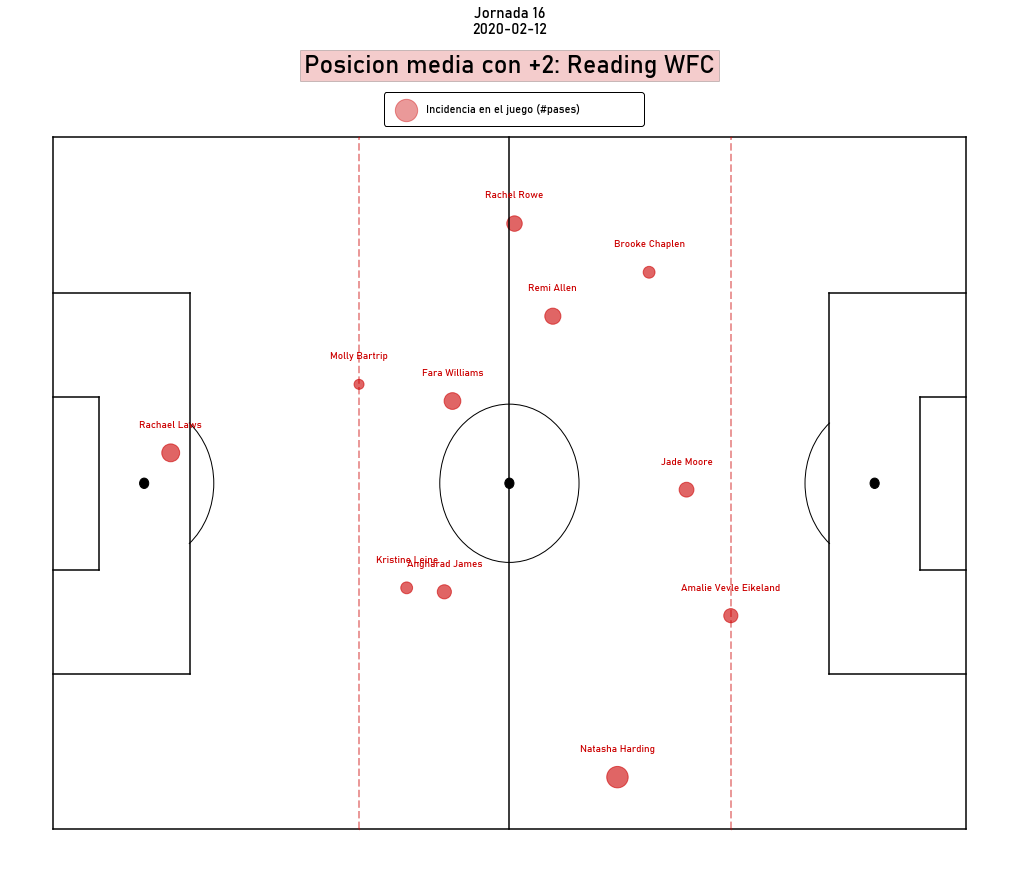

In [66]:
#Celda para gráfico de diferencia
#Sustituir el nombre del dataframe en líneas 7 y 10 y el título del gráfico en línea 74

import matplotlib.pyplot as plt
from matplotlib.patches import Arc

dif=2

if dif == 0:
    dfa=df0
    diferencia="+0"
if dif == 1:
    dfa=dfmas1
    diferencia="+1"
if dif == 2:
    dfa=dfmas2
    diferencia="+2"
if dif == -1:
    dfa=dfmenos1
    diferencia="-1"
if dif == -2:
    dfa=dfmenos2
    diferencia="-2"

jugadoras=dfa.name.unique()
listagrande=[]
for jugadora in jugadoras:
    dfjugadora=dfa.loc[dfa['name'] == jugadora]
    listax=dfjugadora['x'].tolist()
    mediax=round(sum(listax)/len(listax),2)
    listay=dfjugadora['y'].tolist()
    mediay=round(sum(listay)/len(listay),2)
    numpases=len(dfjugadora)
    a=(jugadora,mediax,mediay,numpases)
    listagrande.append(a)
df=pd.DataFrame(listagrande,columns=['Nombre','xmedia','ymedia','numpases'])

fig, ax = plt.subplots(figsize=(18,14))

plt.scatter(x=df['xmedia'],y=df['ymedia'],s = df['numpases']*20,c='#CC0000',alpha=0.6)

    #StatsBomb Pitch
    # Pitch Outline & Centre Line 
plt.plot([0,0],[0,80], color="black")
plt.plot([0,120],[80,80], color="black") 
plt.plot([120,120],[80,0], color="black")
plt.plot([120,0],[0,0], color="black")
plt.plot([60,60],[80,0], color="black")

    # Left Penalty Area
plt.plot([0,18],[62,62],color="black")
plt.plot([0,18],[18,18],color="black")
plt.plot([18,18],[18,62],color="black")

    # Right Penalty Area
plt.plot([120,102],[62,62],color="black")
plt.plot([120,102],[18,18],color="black")
plt.plot([102,102],[18,62],color="black")

    # Left 6-yard Box
plt.plot([0,6],[50,50],color="black")
plt.plot([0,6],[30,30],color="black")
plt.plot([6,6],[50,30],color="black")

    # Right 6-yard Box 
plt.plot([120,114],[30,30],color="black")
plt.plot([120,114],[50,50],color="black")
plt.plot([114,114],[30,50],color="black")

    # Prepare Circles OK
centreCircle = plt.Circle((60,40),9.15,color="black",fill=False)
centreSpot = plt.Circle((60,40),0.6,color="black")
leftPenSpot = plt.Circle((12,40),0.6,color="black")
rightPenSpot = plt.Circle((108,40),0.6,color="black")

    # Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

    # Prepare Arcs based on penalty Spots 
leftArc = Arc((12,40),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
rightArc = Arc((108,40),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")


    # Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

ax.text(60, 92, s = "Jornada {}\n{}".format(jornada,fecha), rotation = 0, size = 15, ha='center', family='bahnschrift')
ax.text(60, 87.5, s = "Posicion media con {}: {}".format(diferencia,propio), rotation = 0, size = 25, bbox=dict(facecolor='#CC0000', alpha=0.2), ha='center', family='bahnschrift')
for i in range(len(df)):
    ax.text(df.iloc[i,1], (df.iloc[i,2])+3, s = df.iloc[i,0], size = 10, ha='center', family='bahnschrift',color='#CC0000')

g2 = plt.scatter([],[], s=500, marker='o', color='#CC0000',alpha=0.4)
g3 = plt.scatter([],[], s=0.0001, marker='o', color='#CC0000',alpha=0)


plt.legend((g2,g3),
       ('Incidencia en el juego (#pases)', ''),
       scatterpoints=1,
       loc=(0.375,0.97),
       ncol=5, prop=dict(family='bahnschrift',weight=500,size=11),
       labelspacing=-3,framealpha=1,edgecolor='black',borderpad=1)

dfordenado=df.sort_values(by='xmedia')
xmin=dfordenado.iloc[1,1]
xmax=dfordenado.iloc[-1,1]

plt.plot([xmin,xmin],[0,80],color='#CC0000', marker='x', linestyle='dashed',linewidth=2, markersize=1,alpha=0.4)
plt.plot([xmax,xmax],[0,80],color='#CC0000', marker='x', linestyle='dashed',linewidth=2, markersize=1,alpha=0.4)

plt.axis('off')
plt.show()